In [1]:
import tensorflow as tf
import deepxde as dde
import numpy as np
import matplotlib.pyplot as plt

Using backend: tensorflow.compat.v1
Other supported backends: tensorflow, pytorch, jax, paddle.
paddle supports more examples now and is recommended.


Instructions for updating:
non-resource variables are not supported in the long term



In [2]:
rho = 1
mu = 1
u_in = 1
D = 1
L = 1
tle = 10
v_i = 1.5
tau_0 = 10

In [3]:
from models.cylinder import Cylinder

geom = Cylinder(center=(0,0,0), radius=D/2, height=L)

[0. 0. 0.]


In [4]:
def boundary_wall(X, on_boundary):
  on_wall = np.logical_and(np.isclose(np.sqrt(X[0] ** 2 + X[1] ** 2),D/2,rtol=1e-05,atol=1e-08), on_boundary)
  return on_wall

def boundary_inlet(X,on_boundary):
  on_inlet = np.logical_and(np.isclose(X[2],0,rtol=1e-05,atol=1e-08),on_boundary)
  return on_inlet

def boundary_outlet(X,on_boundary):
  on_outlet = np.logical_and(np.isclose(X[2],L,rtol=1e-05,atol=1e-08),on_boundary)
  return on_outlet

In [5]:
bc_wall_u = dde.DirichletBC(geom, lambda X:0, boundary_wall, component =0)
bc_wall_v = dde.DirichletBC(geom, lambda X:0., boundary_wall, component =1)

bc_inlet_u = dde.DirichletBC(geom, lambda X:u_in, boundary_inlet, component =0)
bc_inlet_v = dde.DirichletBC(geom, lambda X:0., boundary_inlet, component =1)

bc_outlet_p = dde.DirichletBC(geom, lambda X:0., boundary_outlet, component =2)
bc_outlet_v = dde.DirichletBC(geom, lambda X:0., boundary_outlet, component =1)

In [6]:
def pde(X, Y):
    du_x = dde.grad.jacobian(Y, X, i=0, j=0)
    du_y = dde.grad.jacobian(Y, X, i=0, j=1)
    dv_x = dde.grad.jacobian(Y, X, i=1, j=0)
    dv_y = dde.grad.jacobian(Y, X, i=1, j=1)
    dp_x = dde.grad.jacobian(Y, X, i=2, j=0)
    dp_y = dde.grad.jacobian(Y, X, i=2, j=1)
    du_xx = dde.grad.hessian(Y, X, component=0, i=0, j=0)
    du_yy = dde.grad.hessian(Y, X, component=0, i=1, j=1)
    dv_xx = dde.grad.hessian(Y, X, component=1, i=0, j=0)
    dv_yy = dde.grad.hessian(Y, X, component=1, i=1, j=1)

    # Definições para Bingham para componentes do tensor de tensão
    tau_xy = tau_0 + mu * (du_y + dv_x)
    tau_yx = tau_0 + mu * (dv_x + du_y)
    tau_xx = tau_0 + mu * (du_x + du_x)
    tau_yy = tau_0 + mu * (dv_y + du_y)

    # Derivadas dos tensores de tensão
    dtau_xy_y = dde.grad.jacobian(tau_xy, X, i=0, j=1)
    dtau_yx_x = dde.grad.jacobian(tau_yx, X, i=0, j=0)
    dtau_xx_x = dde.grad.jacobian(tau_xx, X, i=0, j=0)
    dtau_yy_y = dde.grad.jacobian(tau_yy, X, i=0, j=1)

    # Equações de Navier-Stokes modificadas para incluir todos os tensores de tensão
    pde_u = rho * (Y[:,0:1] * du_x + Y[:,1:2] * du_y) + dp_x - dtau_yx_x - dtau_xx_x
    pde_v = rho * (Y[:,0:1] * dv_x + Y[:,1:2] * dv_y) + dp_y - dtau_xy_y - dtau_yy_y
    pde_cont = du_x + dv_y  # Equação de continuidade

    return [pde_u, pde_v, pde_cont]

In [7]:
data = dde.data.PDE(geom,
                    pde,
                    [bc_wall_u,bc_wall_v,bc_inlet_u,bc_inlet_v,bc_outlet_p,bc_outlet_v],
                    num_domain = 2000,
                    num_boundary = 2000,
                    num_test = 2000)

In [13]:
b_points = []
for point in [geom.random_boundary_points(3) for _ in range (100)]:
    b_points.append(point)
    
inside_points = []
for point in [geom.random_points(3) for _ in range (100)]:
    inside_points.append(point)

[[ 0.01084437 -0.49988239  0.61913978]
 [-0.27654547 -0.41656044  0.90165481]
 [-0.38981746 -0.31311715  0.66536826]
 [-0.25941289 -0.22523835  1.        ]
 [ 0.00285676  0.26554758  0.        ]] (100, 5, 3) (10, 3, 3)


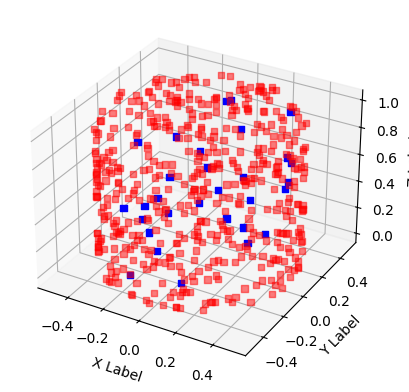

In [14]:
import matplotlib.pyplot as plt
import numpy as np

fig = plt.figure()
ax = fig.add_subplot(projection='3d')

b_points = np.array(b_points)
inside_points = np.array(inside_points)

print(b_points[0],b_points.shape, inside_points.shape)

ax.scatter(b_points[:,:,0], b_points[:,:,1], b_points[:,:,2], marker="s", color="red", alpha=0.5)
ax.scatter(inside_points[:,:,0], inside_points[:,:,1], inside_points[:,:,2], marker="s", color="blue", alpha=1)

ax.set_xlabel('X Label')
ax.set_ylabel('Y Label')
ax.set_zlabel('Z Label')

plt.show()

In [9]:
net = dde.maps.FNN([2]+[64]*5+[3], "tanh","Glorot uniform")

In [10]:
model = dde.Model(data,net)
model.compile("adam",lr=1e-3)

Compiling model...
Building feed-forward neural network...


c:\Users\Pablo\AppData\Local\pypoetry\Cache\virtualenvs\deepxde-custom-4PBOT-FI-py3.10\lib\site-packages\deepxde\nn\tensorflow_compat_v1\fnn.py:116: UserWarning: `tf.layers.dense` is deprecated and will be removed in a future version. Please use `tf.keras.layers.Dense` instead.
  return tf.layers.dense(


'build' took 0.584003 s

'compile' took 21.742687 s



In [11]:
losshistory,train_state = model.train(epochs = 10000)

Training model...



ValueError: Cannot feed value of shape (4018, 3) for Tensor Placeholder_2:0, which has shape (None, 2)

In [ ]:
dde.optimizers.config.set_LBFGS_options(maxiter = 30)
model.compile("L-BFGS")
losshistory,train_state = model.train()
dde.saveplot(losshistory, train_state, issave = False , isplot = False)

In [ ]:
samples= geom.random_points(500000)
result = model.predict(samples)

In [ ]:
color_legend=[[0,1.5],[-0.3,0.3],[0,35]]
for idx in range(3):
  plt.figure(figsize=(20,4))
  plt.scatter(samples[:,0], samples[:,1], c=result[:,idx], cmap='viridis',s=2)
  plt.colorbar()
  plt.clim(color_legend[idx])
  plt.xlim((0-D/2,D-D/2))
  plt.xlim((0-L/2,L-L/2))
  plt.tight_layout()
  plt.show()